In [ ]:
pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 41.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 91.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 70.1 MB/s eta 0:00:00


In [ ]:
from transformers import ViTModel, TFViTModel, ViTFeatureExtractor

In [ ]:
import os
import numpy as np
import pandas as pd
import shutil
from functools import partial
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import cv2

import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten, BatchNormalization, Input, Dropout, Conv2D, Permute
from tensorflow.keras import Model
import albumentations as A

from transformers import TFViTModel

%matplotlib inline


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [ ]:
# ALL_CLASSES = ['anger', 'contempt', 'disgust', 'fear',
#            'happy', 'neutral', 'sad', 'surprised']
CLASSES = ['fear', 'happy', 'neutral', 'sad', 'surprised'] # delete contempt, disgust and anger
NUM_CLASSES = len(CLASSES)
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 8 * 2
LEARNING_RATE = 1e-3
EPOCHS = 60

In [ ]:
NUM_CLASSES

5

# 1. Data preparation

In [ ]:
path_dir = '/kaggle/input/facial-emotion-recognition/'
path_csv = os.path.join(path_dir, '/content/drive/MyDrive/archive (7)/emotions.csv')

In [ ]:
data = pd.read_csv(path_csv)
data

,set_id,gender,age,country
0,0,FEMALE,36,RU
1,1,FEMALE,37,RU
2,2,FEMALE,36,RU
3,3,MALE,29,RU
4,4,FEMALE,43,RU
5,5,MALE,49,RU
6,6,FEMALE,38,RU
7,7,MALE,19,PH
8,8,FEMALE,29,RU
9,9,FEMALE,32,RU


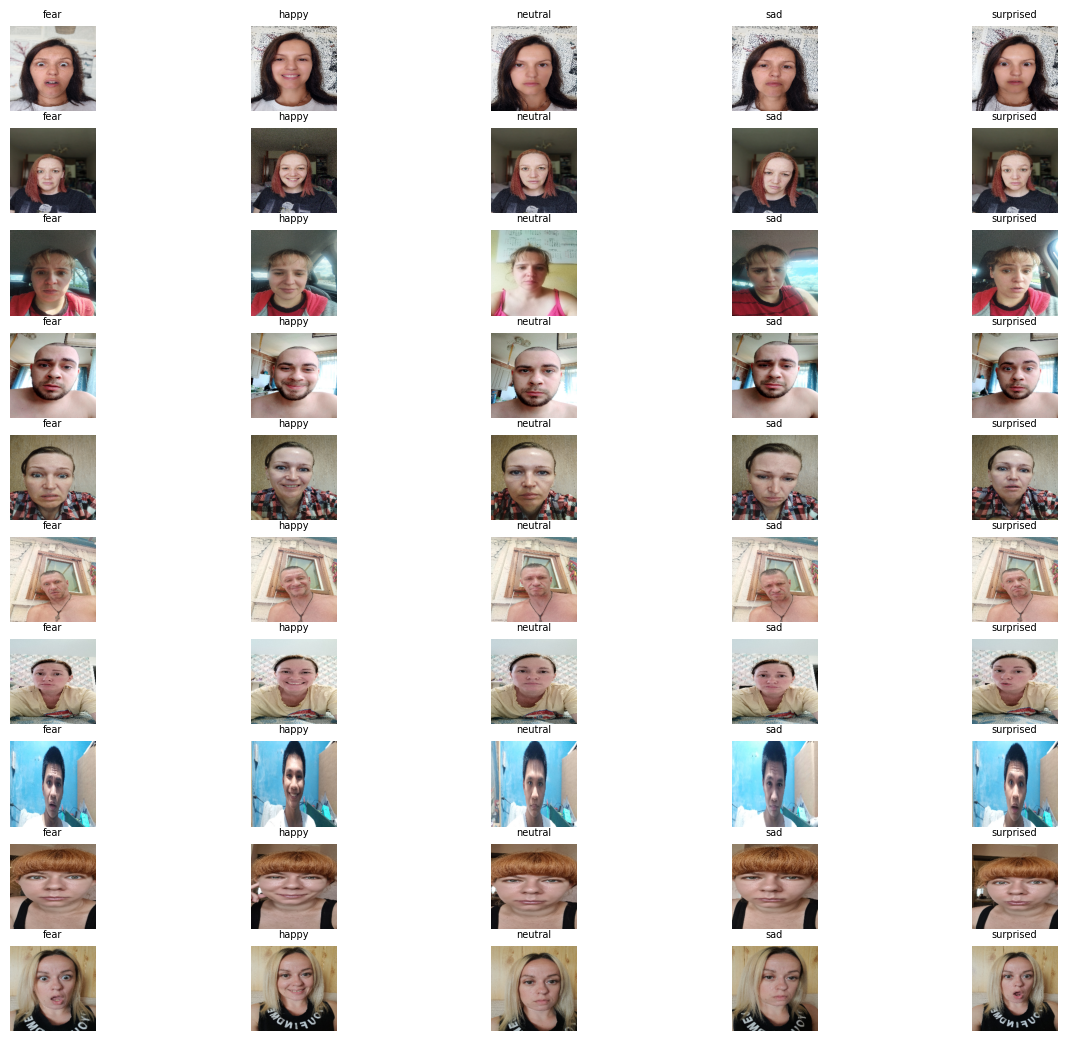

In [ ]:
path_imgs = os.path.join(path_dir, '/content/drive/MyDrive/archive (7)/images')
plt.figure(figsize=(15, 25))
IM_SIZE = (200, 200)
ind = 0
for set_id in data['set_id'][:10]:
    for class_name in CLASSES:
        ind += 1
        path_img = os.path.join(path_imgs, str(set_id), class_name.capitalize() + '.jpg')
        plt.subplot(len(data), len(CLASSES), ind)
        img = cv2.imread(path_img)
        img = cv2.resize(img, IM_SIZE)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.title(class_name, fontsize=7)
        plt.imshow(img)
        plt.axis('off')

In [ ]:
val_ind = [0, 2, 15, 16, 5] # four females and one male for validation
bad_ind = [11]
data_train = data[~data.index.isin(val_ind + bad_ind)].reset_index(drop=True)
data_val = data[data.index.isin(val_ind)].reset_index(drop=True)

In [ ]:
def create_dirs(data, path, new_path):
    if not os.path.exists(new_path):
        os.makedirs(new_path)
    for class_name in CLASSES:
        os.makedirs(os.path.join(new_path, class_name), exist_ok=True)
    for set_id in data['set_id']:
        for class_name in CLASSES:
            path_src = os.path.join(path, str(set_id), class_name.capitalize() + '.jpg')
            path_dist = os.path.join(new_path, class_name, f'{set_id}_{class_name}.jpg')
            shutil.copyfile(path_src, path_dist)

In [ ]:
path_train, path_val = 'input/train', 'input/val'
path_imgs = os.path.join(path_dir, '/content/drive/MyDrive/archive (7)/images')
create_dirs(data_val, path_imgs, path_val)
create_dirs(data_train, path_imgs, path_train)

In [ ]:
!ls $path_train

fear  happy  neutral  sad  surprised


In [ ]:
dataset_train = tf.keras.utils.image_dataset_from_directory(
    directory=path_train,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASSES,
    color_mode='rgb',
    batch_size=None,
    image_size=IMAGE_SIZE,
    shuffle=True,
    seed=1,
    validation_split=None,
)

dataset_val = tf.keras.utils.image_dataset_from_directory(
    directory=path_val,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASSES,
    color_mode='rgb',
    batch_size=None,
    image_size=IMAGE_SIZE,
    shuffle=True,
    seed=1,
    validation_split=None,
)

Found 65 files belonging to 5 classes.
Found 25 files belonging to 5 classes.


In [ ]:
@tf.function
def image_scale(image, label):
    image /= 255.
    return image, label

In [ ]:
dataset_train = dataset_train.map(image_scale,
                                  num_parallel_calls=AUTOTUNE)
dataset_val = dataset_val.map(image_scale,
                                  num_parallel_calls=AUTOTUNE)

In [ ]:
def view_image(ds, num_plt=2):
    image, label = next(iter(ds)) # extract 1 batch from the dataset
    print("shape of images:", image.shape)
    image = image.numpy()
    label = label.numpy()
    print("max, min values in image = ", image.max(), image.min())
    bs = image.shape[0]
    fig = plt.figure(figsize=(10, 5))
    for i in range(bs):
        ax = fig.add_subplot(num_plt, int(np.ceil(bs / num_plt)), i + 1, xticks=[], yticks=[])
        ax.imshow(image[i])
        ax.set_title(f"{CLASSES[np.argmax(label[i])]}", fontsize=7)

shape of images: (16, 224, 224, 3)
max, min values in image =  1.0 0.0


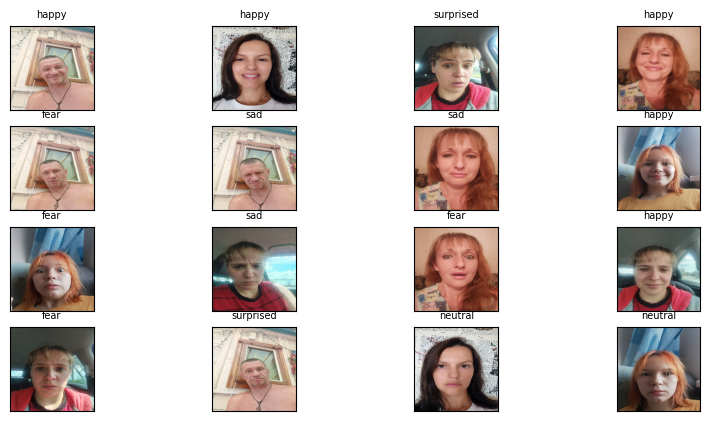

In [ ]:
view_image(dataset_val.batch(16).prefetch(tf.data.AUTOTUNE), num_plt=4)

# Data Augmentation

In [ ]:
transforms = A.Compose([
    A.CropAndPad(percent=0.17, p=0.2),
    A.HorizontalFlip(p=0.4),
    A.OneOf([
        A.MotionBlur(p=.2),
        A.MedianBlur(blur_limit=3, p=0.1),
        A.Blur(blur_limit=3, p=0.1),
    ], p=0.3),
    A.CoarseDropout(p=0.3),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.27, rotate_limit=10, p=0.3),
    A.OneOf([
            A.Sharpen(),
            A.Emboss(),
            A.RandomBrightnessContrast(),
        ], p=0.3),
])

In [ ]:
def aug_fn(image):
    data = {'image': image}
    image = transforms(**data)['image']
    return image

input_prepoccess_f = lambda image, label: (2. * image - 1., label)

@tf.function
def image_preprocessing(image, label, scale=True):
    image = tf.numpy_function(func=aug_fn, inp=[image],
                              Tout=tf.float32)
    image.set_shape((*IMAGE_SIZE, 3))
    image = tf.clip_by_value(image, clip_value_min=0.,
                               clip_value_max=1.)
    # mobilenet_v2 preprocess of input
    if scale:
        image = 2. * image - 1.
    return image, label

In [ ]:
dataset_train_ = dataset_train.map(partial(image_preprocessing, scale=False), num_parallel_calls=AUTOTUNE
                                  ).shuffle(buffer_size = 8,
                                      reshuffle_each_iteration = True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

shape of images: (16, 224, 224, 3)
max, min values in image =  1.0 0.0


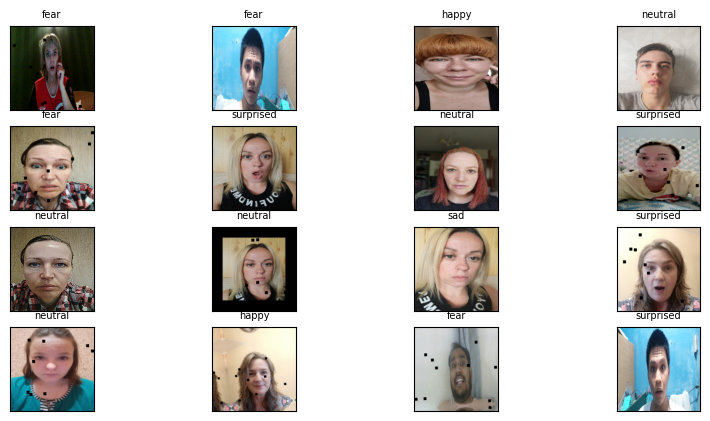

In [ ]:
view_image(dataset_train_, num_plt=4) # visualize augmented data

In [ ]:
buffer_size = len(data)
dataset_train_m = dataset_train.map(image_preprocessing, num_parallel_calls=AUTOTUNE
                                  ).shuffle(buffer_size = buffer_size,
                                      reshuffle_each_iteration = True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
dataset_val_m = dataset_val.map(input_prepoccess_f, num_parallel_calls=AUTOTUNE
                                  ).shuffle(buffer_size = buffer_size,
                                      reshuffle_each_iteration = True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# 2. Model training

EfficientNet

In [ ]:
inputs = Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
backbone = keras.applications.efficientnet_v2.EfficientNetV2B3(
    include_top=False,
    weights='imagenet',
    input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
    pooling=None,
    include_preprocessing=False,
)
backbone.trainable = False
x = backbone(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
outputs = Dense(NUM_CLASSES, activation='softmax')(x)

model_cls = Model(inputs, outputs, name='facial_exp_cls_efficientnet') # 41 - 50 6 classes B2 32, 0.001, 128
model_cls.summary()

52606240/52606240 [==============================] - 0s 0us/step
Model: "facial_exp_cls_efficientnet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b3 (Functio  (None, 7, 7, 1536)        12930622  
 nal)                                                            
                                                                 
 global_average_pooling2d (  (None, 1536)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1536)              0         
                                                                 
 batch_normalization (Batch  (None, 1536)              6144      
 Normalization)                         

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
loss = keras.losses.CategoricalCrossentropy(from_logits=False)
metrics = [keras.metrics.CategoricalAccuracy(), keras.metrics.TopKCategoricalAccuracy(k=2)]
model_cls.compile(optimizer=optimizer,
             loss=loss,
             metrics=metrics)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.8,
                              patience=3, min_lr=5e-5)
early_stop = keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=5,
    start_from_epoch=10,
    restore_best_weights=True,
)

In [ ]:
history = model_cls.fit(dataset_train_m, epochs=EPOCHS,
          validation_data=dataset_val_m, verbose=1, callbacks=[reduce_lr, early_stop])

# ViT

In [ ]:
buffer_size = len(data)
dataset_train_t = dataset_train.map(partial(image_preprocessing, scale=False), num_parallel_calls=AUTOTUNE
                                  ).shuffle(buffer_size = buffer_size,
                                      reshuffle_each_iteration = True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
dataset_val_t = dataset_val.shuffle(buffer_size = buffer_size,
                                      reshuffle_each_iteration = True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
model_name = 'google/vit-base-patch16-224-in21k'
base_model = TFViTModel.from_pretrained(model_name)
inputs = Input(shape=(224, 224, 3))
x = Permute((3, 1, 2))(inputs)
base_model.trainable = False
x = base_model.vit(x)[0]
x = keras.layers.GlobalAveragePooling1D()(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu', kernel_regularizer=keras.regularizers.L2(0.01))(x) # batchnorm
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
outputs = Dense(NUM_CLASSES, activation='softmax')(x)
hf_model = Model(inputs=inputs, outputs=outputs, name='ViT_cls')

In [ ]:
hf_model.summary()

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
loss = keras.losses.CategoricalCrossentropy(from_logits=False)
metrics = [keras.metrics.CategoricalAccuracy(), keras.metrics.TopKCategoricalAccuracy(k=2)]
hf_model.compile(optimizer=optimizer,
             loss=loss,
             metrics=metrics)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.8,
                              patience=3, min_lr=5e-5)
early_stop = keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=5,
    start_from_epoch=10,
)

In [ ]:
history = hf_model.fit(dataset_train_t, epochs=EPOCHS,
          validation_data=dataset_val_t, verbose=1, callbacks=[reduce_lr, early_stop])

Epoch 1/60
5/5 [==============================] - ETA: 0s - loss: 4.4943 - categorical_accuracy: 0.1692 - top_k_categorical_accuracy: 0.3385 

5/5 [==============================] - 119s 21s/step - loss: 4.4943 - categorical_accuracy: 0.1692 - top_k_categorical_accuracy: 0.3385 - val_loss: 3.7729 - val_categorical_accuracy: 0.1600 - val_top_k_categorical_accuracy: 0.3600 - lr: 0.0010
Epoch 2/60
5/5 [==============================] - ETA: 0s - loss: 4.1769 - categorical_accuracy: 0.2615 - top_k_categorical_accuracy: 0.4154 

5/5 [==============================] - 83s 16s/step - loss: 4.1769 - categorical_accuracy: 0.2615 - top_k_categorical_accuracy: 0.4154 - val_loss: 3.7284 - val_categorical_accuracy: 0.2800 - val_top_k_categorical_accuracy: 0.5200 - lr: 0.0010
Epoch 3/60
5/5 [==============================] - ETA: 0s - loss: 3.9934 - categorical_accuracy: 0.2308 - top_k_categorical_accuracy: 0.4923 

5/5 [==============================] - 99s 20s/step - loss: 3.9934 - categorical_accuracy: 0.2308 - top_k_categorical_accuracy: 0.4923 - val_loss: 3.6862 - val_categorical_accuracy: 0.3600 - val_top_k_categorical_accuracy: 0.6000 - lr: 0.0010
Epoch 4/60
5/5 [==============================] - ETA: 0s - loss: 3.5143 - categorical_accuracy: 0.4308 - top_k_categorical_accuracy: 0.6769 

5/5 [==============================] - 97s 20s/step - loss: 3.5143 - categorical_accuracy: 0.4308 - top_k_categorical_accuracy: 0.6769 - val_loss: 3.6450 - val_categorical_accuracy: 0.3600 - val_top_k_categorical_accuracy: 0.6400 - lr: 0.0010
Epoch 5/60
5/5 [==============================] - ETA: 0s - loss: 3.6672 - categorical_accuracy: 0.2769 - top_k_categorical_accuracy: 0.5846 

5/5 [==============================] - 98s 20s/step - loss: 3.6672 - categorical_accuracy: 0.2769 - top_k_categorical_accuracy: 0.5846 - val_loss: 3.6066 - val_categorical_accuracy: 0.3200 - val_top_k_categorical_accuracy: 0.6400 - lr: 0.0010
Epoch 6/60
5/5 [==============================] - ETA: 0s - loss: 3.5421 - categorical_accuracy: 0.3231 - top_k_categorical_accuracy: 0.6615 

5/5 [==============================] - 99s 21s/step - loss: 3.5421 - categorical_accuracy: 0.3231 - top_k_categorical_accuracy: 0.6615 - val_loss: 3.5667 - val_categorical_accuracy: 0.4000 - val_top_k_categorical_accuracy: 0.8000 - lr: 0.0010
Epoch 7/60
5/5 [==============================] - ETA: 0s - loss: 3.2407 - categorical_accuracy: 0.5231 - top_k_categorical_accuracy: 0.7846 

5/5 [==============================] - 102s 21s/step - loss: 3.2407 - categorical_accuracy: 0.5231 - top_k_categorical_accuracy: 0.7846 - val_loss: 3.5299 - val_categorical_accuracy: 0.4400 - val_top_k_categorical_accuracy: 0.7600 - lr: 0.0010
Epoch 8/60
5/5 [==============================] - ETA: 0s - loss: 3.3118 - categorical_accuracy: 0.5231 - top_k_categorical_accuracy: 0.6615 

5/5 [==============================] - 78s 15s/step - loss: 3.3118 - categorical_accuracy: 0.5231 - top_k_categorical_accuracy: 0.6615 - val_loss: 3.4926 - val_categorical_accuracy: 0.5600 - val_top_k_categorical_accuracy: 0.7600 - lr: 0.0010
Epoch 9/60
5/5 [==============================] - ETA: 0s - loss: 3.3415 - categorical_accuracy: 0.4462 - top_k_categorical_accuracy: 0.6462 

5/5 [==============================] - 98s 20s/step - loss: 3.3415 - categorical_accuracy: 0.4462 - top_k_categorical_accuracy: 0.6462 - val_loss: 3.4595 - val_categorical_accuracy: 0.5600 - val_top_k_categorical_accuracy: 0.7200 - lr: 0.0010
Epoch 10/60
5/5 [==============================] - ETA: 0s - loss: 3.1328 - categorical_accuracy: 0.5385 - top_k_categorical_accuracy: 0.7846 

5/5 [==============================] - 96s 20s/step - loss: 3.1328 - categorical_accuracy: 0.5385 - top_k_categorical_accuracy: 0.7846 - val_loss: 3.4267 - val_categorical_accuracy: 0.5600 - val_top_k_categorical_accuracy: 0.7200 - lr: 0.0010
Epoch 11/60
5/5 [==============================] - ETA: 0s - loss: 3.1517 - categorical_accuracy: 0.5385 - top_k_categorical_accuracy: 0.7846 

5/5 [==============================] - 79s 16s/step - loss: 3.1517 - categorical_accuracy: 0.5385 - top_k_categorical_accuracy: 0.7846 - val_loss: 3.3989 - val_categorical_accuracy: 0.5600 - val_top_k_categorical_accuracy: 0.7200 - lr: 0.0010
Epoch 12/60
5/5 [==============================] - ETA: 0s - loss: 3.0691 - categorical_accuracy: 0.6000 - top_k_categorical_accuracy: 0.7385 

5/5 [==============================] - 97s 20s/step - loss: 3.0691 - categorical_accuracy: 0.6000 - top_k_categorical_accuracy: 0.7385 - val_loss: 3.3736 - val_categorical_accuracy: 0.5600 - val_top_k_categorical_accuracy: 0.6800 - lr: 0.0010
Epoch 13/60
5/5 [==============================] - ETA: 0s - loss: 2.9035 - categorical_accuracy: 0.5231 - top_k_categorical_accuracy: 0.8154 

5/5 [==============================] - 98s 20s/step - loss: 2.9035 - categorical_accuracy: 0.5231 - top_k_categorical_accuracy: 0.8154 - val_loss: 3.3439 - val_categorical_accuracy: 0.6000 - val_top_k_categorical_accuracy: 0.6800 - lr: 0.0010
Epoch 14/60
5/5 [==============================] - ETA: 0s - loss: 2.9176 - categorical_accuracy: 0.6308 - top_k_categorical_accuracy: 0.8000 

5/5 [==============================] - 78s 15s/step - loss: 2.9176 - categorical_accuracy: 0.6308 - top_k_categorical_accuracy: 0.8000 - val_loss: 3.3143 - val_categorical_accuracy: 0.6000 - val_top_k_categorical_accuracy: 0.7200 - lr: 0.0010
Epoch 15/60
5/5 [==============================] - ETA: 0s - loss: 2.9916 - categorical_accuracy: 0.5077 - top_k_categorical_accuracy: 0.6923 

5/5 [==============================] - 96s 20s/step - loss: 2.9916 - categorical_accuracy: 0.5077 - top_k_categorical_accuracy: 0.6923 - val_loss: 3.2822 - val_categorical_accuracy: 0.6400 - val_top_k_categorical_accuracy: 0.7200 - lr: 0.0010
Epoch 16/60
5/5 [==============================] - ETA: 0s - loss: 2.9714 - categorical_accuracy: 0.6000 - top_k_categorical_accuracy: 0.7846 

5/5 [==============================] - 83s 17s/step - loss: 2.9714 - categorical_accuracy: 0.6000 - top_k_categorical_accuracy: 0.7846 - val_loss: 3.2550 - val_categorical_accuracy: 0.6000 - val_top_k_categorical_accuracy: 0.6800 - lr: 0.0010
Epoch 17/60
5/5 [==============================] - ETA: 0s - loss: 2.8989 - categorical_accuracy: 0.6000 - top_k_categorical_accuracy: 0.7692 

5/5 [==============================] - 97s 20s/step - loss: 2.8989 - categorical_accuracy: 0.6000 - top_k_categorical_accuracy: 0.7692 - val_loss: 3.2323 - val_categorical_accuracy: 0.5200 - val_top_k_categorical_accuracy: 0.6400 - lr: 0.0010
Epoch 18/60
5/5 [==============================] - ETA: 0s - loss: 2.7111 - categorical_accuracy: 0.6308 - top_k_categorical_accuracy: 0.8308 

5/5 [==============================] - 96s 20s/step - loss: 2.7111 - categorical_accuracy: 0.6308 - top_k_categorical_accuracy: 0.8308 - val_loss: 3.2062 - val_categorical_accuracy: 0.5200 - val_top_k_categorical_accuracy: 0.6000 - lr: 0.0010
Epoch 19/60
5/5 [==============================] - ETA: 0s - loss: 2.5915 - categorical_accuracy: 0.6769 - top_k_categorical_accuracy: 0.8615 

5/5 [==============================] - 95s 20s/step - loss: 2.5915 - categorical_accuracy: 0.6769 - top_k_categorical_accuracy: 0.8615 - val_loss: 3.1810 - val_categorical_accuracy: 0.5200 - val_top_k_categorical_accuracy: 0.6400 - lr: 0.0010
Epoch 20/60
5/5 [==============================] - ETA: 0s - loss: 2.7242 - categorical_accuracy: 0.5231 - top_k_categorical_accuracy: 0.8923 

5/5 [==============================] - 76s 15s/step - loss: 2.7242 - categorical_accuracy: 0.5231 - top_k_categorical_accuracy: 0.8923 - val_loss: 3.1523 - val_categorical_accuracy: 0.5200 - val_top_k_categorical_accuracy: 0.6400 - lr: 0.0010
Epoch 21/60
5/5 [==============================] - ETA: 0s - loss: 2.6442 - categorical_accuracy: 0.6923 - top_k_categorical_accuracy: 0.8615 

5/5 [==============================] - 77s 15s/step - loss: 2.6442 - categorical_accuracy: 0.6923 - top_k_categorical_accuracy: 0.8615 - val_loss: 3.1216 - val_categorical_accuracy: 0.4400 - val_top_k_categorical_accuracy: 0.6400 - lr: 0.0010
Epoch 22/60
5/5 [==============================] - ETA: 0s - loss: 2.4880 - categorical_accuracy: 0.7538 - top_k_categorical_accuracy: 0.8923 

5/5 [==============================] - 98s 20s/step - loss: 2.4880 - categorical_accuracy: 0.7538 - top_k_categorical_accuracy: 0.8923 - val_loss: 3.0965 - val_categorical_accuracy: 0.4400 - val_top_k_categorical_accuracy: 0.6800 - lr: 0.0010
Epoch 23/60
5/5 [==============================] - ETA: 0s - loss: 2.5855 - categorical_accuracy: 0.6154 - top_k_categorical_accuracy: 0.8923 

5/5 [==============================] - 77s 15s/step - loss: 2.5855 - categorical_accuracy: 0.6154 - top_k_categorical_accuracy: 0.8923 - val_loss: 3.0661 - val_categorical_accuracy: 0.4400 - val_top_k_categorical_accuracy: 0.7200 - lr: 0.0010
Epoch 24/60
5/5 [==============================] - ETA: 0s - loss: 2.3622 - categorical_accuracy: 0.7538 - top_k_categorical_accuracy: 0.9231 

5/5 [==============================] - 96s 20s/step - loss: 2.3622 - categorical_accuracy: 0.7538 - top_k_categorical_accuracy: 0.9231 - val_loss: 3.0298 - val_categorical_accuracy: 0.4800 - val_top_k_categorical_accuracy: 0.7600 - lr: 0.0010
Epoch 25/60
5/5 [==============================] - ETA: 0s - loss: 2.4642 - categorical_accuracy: 0.7077 - top_k_categorical_accuracy: 0.8615 

5/5 [==============================] - 95s 20s/step - loss: 2.4642 - categorical_accuracy: 0.7077 - top_k_categorical_accuracy: 0.8615 - val_loss: 2.9919 - val_categorical_accuracy: 0.6000 - val_top_k_categorical_accuracy: 0.7600 - lr: 0.0010
Epoch 26/60
5/5 [==============================] - ETA: 0s - loss: 2.4738 - categorical_accuracy: 0.6923 - top_k_categorical_accuracy: 0.9231 

5/5 [==============================] - 97s 20s/step - loss: 2.4738 - categorical_accuracy: 0.6923 - top_k_categorical_accuracy: 0.9231 - val_loss: 2.9583 - val_categorical_accuracy: 0.6000 - val_top_k_categorical_accuracy: 0.8000 - lr: 0.0010
Epoch 27/60
5/5 [==============================] - ETA: 0s - loss: 2.4639 - categorical_accuracy: 0.6615 - top_k_categorical_accuracy: 0.8615 

5/5 [==============================] - 95s 20s/step - loss: 2.4639 - categorical_accuracy: 0.6615 - top_k_categorical_accuracy: 0.8615 - val_loss: 2.9267 - val_categorical_accuracy: 0.5600 - val_top_k_categorical_accuracy: 0.8000 - lr: 0.0010
Epoch 28/60
5/5 [==============================] - ETA: 0s - loss: 2.4626 - categorical_accuracy: 0.6769 - top_k_categorical_accuracy: 0.8769 

5/5 [==============================] - 96s 20s/step - loss: 2.4626 - categorical_accuracy: 0.6769 - top_k_categorical_accuracy: 0.8769 - val_loss: 2.9011 - val_categorical_accuracy: 0.5600 - val_top_k_categorical_accuracy: 0.8000 - lr: 0.0010
Epoch 29/60
5/5 [==============================] - ETA: 0s - loss: 2.3505 - categorical_accuracy: 0.7077 - top_k_categorical_accuracy: 0.8615 

5/5 [==============================] - 96s 20s/step - loss: 2.3505 - categorical_accuracy: 0.7077 - top_k_categorical_accuracy: 0.8615 - val_loss: 2.8816 - val_categorical_accuracy: 0.5600 - val_top_k_categorical_accuracy: 0.8000 - lr: 0.0010
Epoch 30/60
5/5 [==============================] - ETA: 0s - loss: 2.3121 - categorical_accuracy: 0.7231 - top_k_categorical_accuracy: 0.8923 

5/5 [==============================] - 96s 20s/step - loss: 2.3121 - categorical_accuracy: 0.7231 - top_k_categorical_accuracy: 0.8923 - val_loss: 2.8586 - val_categorical_accuracy: 0.4800 - val_top_k_categorical_accuracy: 0.8000 - lr: 0.0010
Epoch 31/60
5/5 [==============================] - ETA: 0s - loss: 2.3484 - categorical_accuracy: 0.6615 - top_k_categorical_accuracy: 0.8462 

5/5 [==============================] - 96s 20s/step - loss: 2.3484 - categorical_accuracy: 0.6615 - top_k_categorical_accuracy: 0.8462 - val_loss: 2.8334 - val_categorical_accuracy: 0.5200 - val_top_k_categorical_accuracy: 0.8000 - lr: 0.0010


# 3. ViT model evaluation

In [ ]:
input_prepoccess_f = lambda image, label: (2. * image - 1., label)
dataset_t_ = tf.keras.utils.image_dataset_from_directory(
    directory=path_val,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASSES,
    color_mode='rgb',
    batch_size=None,
    image_size=IMAGE_SIZE,
    shuffle=False,
    validation_split=None,
).map(image_scale, num_parallel_calls=AUTOTUNE)
dataset_t_t = dataset_t_.batch(1)

In [ ]:
pred = hf_model.predict(dataset_t_t)

In [ ]:
def view_image_pred(ds, pred, num_plt=4):
    bs = pred.shape[0]
    fig = plt.figure(figsize=(10, 15))
    for i, (image, label) in enumerate(ds.as_numpy_iterator()):
        ax = fig.add_subplot(num_plt, bs // num_plt, i + 1, xticks=[], yticks=[])
        ax.imshow((image[0] + 1.) * 0.5)
        ax.set_title(f"t={CLASSES[np.argmax(label)]}, p={np.array(CLASSES)[np.argsort(pred[i])[-2:][::-1]]}", fontsize=7)

In [ ]:
view_image_pred(dataset_t_t, pred, num_plt=5) # true (t) label and predicted (p) with two highest probability

In [ ]:
y_true = np.stack([label[0] for _, label in dataset_t_t.as_numpy_iterator()])
y_true = np.argmax(y_true, axis=-1)
y_pred = np.argmax(pred, axis=-1)
print(classification_report(y_true, y_pred, target_names=CLASSES, digits=2))

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred), display_labels=CLASSES)
disp.plot()
plt.show()